In This notebook we utilize the model previously created to run RUL prediction on the engines in the test data files.

In [1]:
import pandas as pd
import numpy as np

import glob
import os
from tqdm import tqdm

# Setting seed for reproducability
np.random.seed(101)  
PYTHONHASHSEED = 0

import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation

from sklearn.externals import joblib 

import matplotlib.pyplot as plt
%matplotlib inline

from data_generator import TSDataGenerator
import data_util
from util import rmse


Using TensorFlow backend.


## Setup

In [2]:
DATA_DIR = os.path.abspath("./data")
MODEL_DIR = os.path.abspath("./model")


In [3]:
cols = ['id', 'cycle' ]

# Three operational setting columns
setting_cols = ['setting' + str(i) for i in range(1,4)]
cols.extend(setting_cols)

# Twenty one sensor columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
cols.extend(sensor_cols)

# The data already comes sorted, but to be on the safe we will 
# maintain an order based on engine and cycle and ascending cycle.
sort_cols = ['id','cycle']


### Load Model

In [4]:
# Feature columns. 
feature_cols = ['cycle_norm', 'condition']

# Label columns
label_cols = ['RUL']

# Three operational setting columns
setting_cols = ['setting' + str(i) for i in range(1,4)]
feature_cols.extend(setting_cols)

# Twenty one sensor columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
feature_cols.extend(sensor_cols)


Keras requires that you use same batch size in predicting as you used when training. Here we will create the same model, but parameterize the shapes. This will allow us to specify a model with a batch size of 1. 

In [5]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Masking, Activation
from sklearn import preprocessing

def create_model(batch_size, seq_length, num_features, num_labels):
    # build the network

    model = Sequential()

    model.add(LSTM(
             input_shape=(seq_length, num_features),
             units=128,
             batch_input_shape=(batch_size, seq_length, num_features),
             stateful=False,
             return_sequences=False))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))

    model.add(Dense(units=num_labels, activation='relu'))
    
    return model


In [6]:
sequence_length = 25              # Size of the series time window.
batch_size = 1                    # Number of time series sequences that will predict on
num_features = len(feature_cols)
num_labels = len(label_cols)

model_path = os.path.join(MODEL_DIR,'engine_model.h5')
print("Loading model: ", model_path)

# Device to load the neural network on. /cpu:0 or /gpu:0
# Use CPU device to avoid conflict if training has the GPU
DEVICE = "/cpu:0" 
#DEVICE = "/gpu:0"

with tf.device(DEVICE):
    custom_objects={'rmse':rmse}
    inf_model = create_model(batch_size, sequence_length, num_features, num_labels)
    inf_model.load_weights(model_path)
#    inf_model = load_model(model_path, custom_objects=custom_objects)

inf_model.summary()


Loading model:  /home/saad/workspaces/predictive-maintenance-lstm/model/engine_model.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 128)                  79360     
_________________________________________________________________
dense_1 (Dense)              (1, 64)                   8256      
_________________________________________________________________
dense_2 (Dense)              (1, 32)                   2080      
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    33        
Total params: 89,729
Trainable params: 89,729
Non-trainable params: 0
_________________________________________________________________


### Load Pipeline


In [7]:
pipeline_path = os.path.join(MODEL_DIR, 'engine_pipeline.pkl')
print("Loading pipeline: ", pipeline_path)

pipeline = joblib.load(pipeline_path) 


Loading pipeline:  /home/saad/workspaces/predictive-maintenance-lstm/model/engine_pipeline.pkl


## Prediction

We will iterate over all the test files to run a prediction on a single batch for each engine's containing its last sequence_length events.

In [8]:
path = os.path.join(DATA_DIR, "test_FD*.txt")
all_test_files = sorted(glob.glob(path))

path = os.path.join(DATA_DIR, "RUL_FD*.txt")
all_rul_files = sorted(glob.glob(path))

all_test_files

['/home/saad/workspaces/predictive-maintenance-lstm/data/test_FD001.txt',
 '/home/saad/workspaces/predictive-maintenance-lstm/data/test_FD002.txt',
 '/home/saad/workspaces/predictive-maintenance-lstm/data/test_FD003.txt',
 '/home/saad/workspaces/predictive-maintenance-lstm/data/test_FD004.txt']

In [9]:
test_prediction_results = []

for i, test_X_path in enumerate(all_test_files):
    # Read in the features
    test_df = data_util.load_data([test_X_path], cols, sort_cols)

    # Read in the labels (RUL)
    test_rul_df = data_util.load_rul_data([all_rul_files[i]], ['id', 'RUL_actual'])

    # Calculate the RUL and merge back to the test dataframe
    test_df = data_util.calc_test_rul(test_df, test_rul_df)

    # Transform
    test_df = data_util.transform(test_df, pipeline)
    
    results = []

    for engine_id in test_df['id'].unique():
        engine_df = test_df[ test_df['id'] == engine_id]

        # Skip the engine with less then 25 for now, TODO pad
        if engine_df.shape[0] > sequence_length:
            last_batch = engine_df[feature_cols].iloc[-sequence_length:].values.reshape(batch_size, sequence_length, num_features)
            rul = engine_df['RUL'].iloc[-1:].values[0]
            prediction = inf_model.predict_on_batch(last_batch)[0,0]

            results.append([engine_id, prediction, rul, prediction-rul])
            
    test_prediction_results.append(np.array(results))
    

(100, 2)
(259, 2)
(100, 2)
(248, 2)


Plot the results by engine id. Those predictions above zero exceeded the actual RUL, it is preferable to be less optimistic.

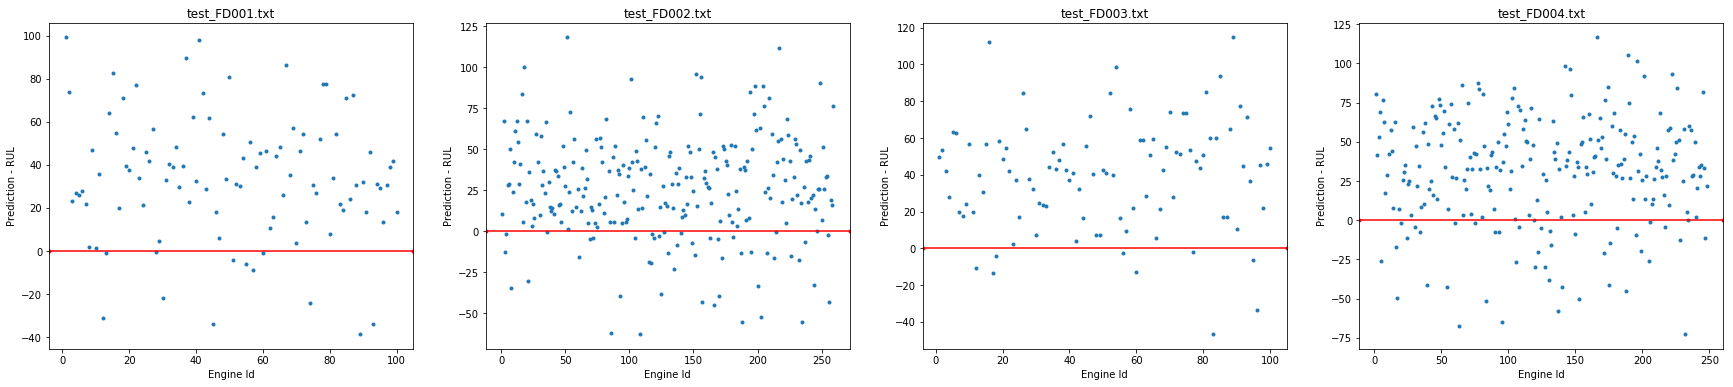

In [10]:
fig = plt.figure(figsize=(30, 6))
for i, r in enumerate(test_prediction_results):
    ax = plt.subplot(1, 4, i+1)
    # Subtract the base to show the original engine id
    ax.scatter(r[:,0] - data_util.path_to_id_base(all_test_files[i]), r[:,3], marker='.',)
    
    ax.set_xlabel("Engine Id")
    ax.set_ylabel("Prediction - RUL")
    ax.set_title(os.path.basename(all_test_files[i]))

    ax.axhline(y=0, color='r', marker='.')

plt.show()

Let's plot a single file for a close-up view.

In [11]:
results = test_prediction_results[1] # 1 is test_FD002

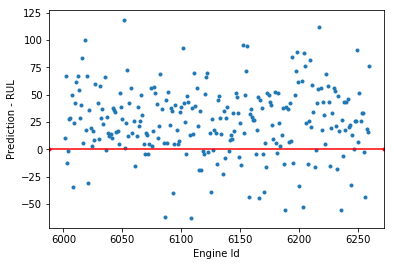

In [12]:
plt.scatter(results[:,0], results[:,3], marker='.', label="Diff")
plt.xlabel("Engine Id")
plt.ylabel("Prediction - RUL")

plt.axhline(y=0, color='r', marker='.')

plt.show()


This is another view based only on the RUL, not the engine.

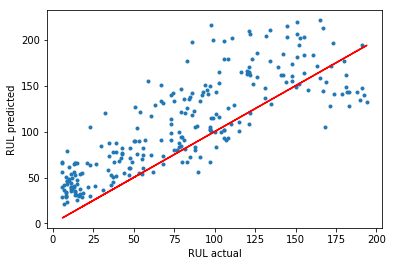

In [13]:
plt.scatter(results[:,2], results[:,1], marker='.')
plt.plot(results[:,2], results[:,2], 'r')
plt.xlabel("RUL actual")
plt.ylabel("RUL predicted")

plt.show()
